# Random Forest for Stock Price Prediction

In this project I will use a random forest model to predict stock pricing. The goal is to determine whether an increase in the price of a certain stock is expected in order to buy it at a favorable time.

The method I will follow within the following notebook involves a series of steps to acquire and clean the data and implement an optimized model. In detail I will perform the following steps:
- dawnload the price history of a given stock from Yahoo Finance;
- data exploration and cleaning;
- dataset setup;
- model implementation and testing;
- setup of a backtesting engine;
- optimization of model accuracy.

## Data Import, Analysis and Viasualization

Data will be saved in a dedicated json file so that it does not have to be re-downloaded each time. The file will be created if it does not exist yet.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import json
import os
import sys
sys.stderr = open(os.devnull, "w")  # silence stderr

In [2]:
file_path = "financial_data.json"

if os.path.exists(file_path):
    with open(file_path) as f:
        price_df = pd.read_json(file_path)
else:
    # here the name of the stock of interest is specified
    price = yf.Ticker("GOOGL")
    price_df = price.history(period="max")
    price_df.to_json(file_path)

In [3]:
price_df.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2004-08-19 04:00:00,2.502503,2.604104,2.401401,2.511011,893181924,0,0.0
2004-08-20 04:00:00,2.527778,2.729730,2.515015,2.710460,456686856,0,0.0
2004-08-23 04:00:00,2.771522,2.839840,2.728979,2.737738,365122512,0,0.0
2004-08-24 04:00:00,2.783784,2.792793,2.591842,2.624374,304946748,0,0.0
2004-08-25 04:00:00,2.626627,2.702703,2.599600,2.652653,183772044,0,0.0


In the following, the **general information** regarding the dataframe is shown. As you can see, there is no null data. However we notice that stock doesn't trade every day (there is no trading on weekends and holidays), so some dates are missing.

In [4]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4608 entries, 2004-08-19 04:00:00 to 2022-12-06 05:00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          4608 non-null   float64
 1   High          4608 non-null   float64
 2   Low           4608 non-null   float64
 3   Close         4608 non-null   float64
 4   Volume        4608 non-null   int64  
 5   Dividends     4608 non-null   int64  
 6   Stock Splits  4608 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 288.0 KB


Graphs representing data trends are now displayed. Specifically, the closing stock price, daily percentage variation, and trading volume are shown.

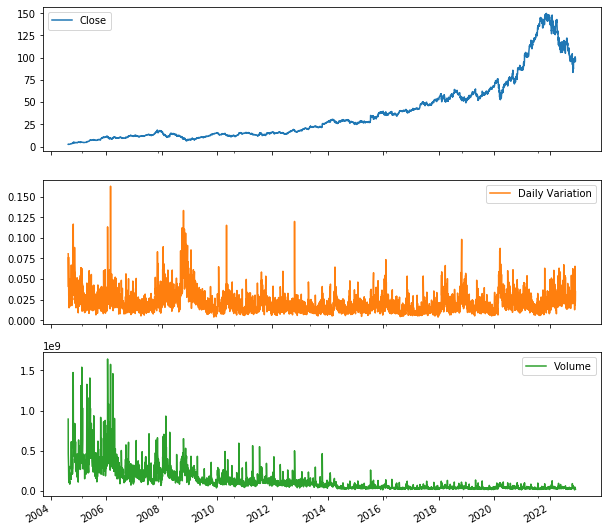

In [5]:
price_df["Daily Variation"] = (price_df["High"] - price_df["Low"]) / price_df["Close"]
price_df.plot.line(y=["Close", "Daily Variation", "Volume"], use_index=True, subplots=True, figsize=(10, 10))
plt.show()

## Data Preprocessing

We begin by identifying the target of the predictions for the model to be implemented. The target is to identify whether the price will go up or down the next day based on the current day. If the price went up, the target will be **1**; if it went down, it will be **0**.

I add two columns to the original dataframe: one for the target {0, 1}, and one to record the next day's closing price.

In [6]:
data = price_df[["Close"]]
data = data.rename(columns = {'Close':'Future Close'})

data["Target"] = price_df.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]   

price_shifted = price_df.copy()
price_shifted = price_shifted.shift(1)

predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(price_shifted[predictors]).iloc[1:]

data.head(5)

,Future Close,Target,Close,Volume,Open,High,Low
2004-08-20 04:00:00,2.710460,1.0,2.511011,893181924.0,2.502503,2.604104,2.401401
2004-08-23 04:00:00,2.737738,1.0,2.710460,456686856.0,2.527778,2.729730,2.515015
2004-08-24 04:00:00,2.624374,0.0,2.737738,365122512.0,2.771522,2.839840,2.728979
2004-08-25 04:00:00,2.652653,1.0,2.624374,304946748.0,2.783784,2.792793,2.591842
2004-08-26 04:00:00,2.700450,1.0,2.652653,183772044.0,2.626627,2.702703,2.599600


## Model Design and Training

The machine learning model we will use for making price predictions is the random forest classifier. The advantage of using such a model is that it can capture nonlinear relationships in the data.

Because the data are temporally ordered, we cannot use cross-validation to check the accuracy of the implemented model.  For this reason, we will split the data sequentially. We will start by predicting only the last 100 rows using the previous ones.

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

train = data.iloc[:-100]
test = data.iloc[-100:]

In [8]:
# A random grid is defined in order to seach for the optimal forest with a randomized search
random_grid  = {'bootstrap': [True],
                'max_depth': [20, 25, 30, 35, 40],
                'max_features': ['auto'],
                'min_samples_leaf': [1, 2, 4, 6],
                'min_samples_split': [25, 50, 75, 100],
                'n_estimators': [100, 200, 300, 400]}

In [9]:
RFC = RandomForestClassifier()
RS = RandomizedSearchCV(estimator = RFC, 
                        param_distributions = random_grid, 
                        n_iter = 35, 
                        cv = 4)
RS.fit(train[predictors], train["Target"])

RandomizedSearchCV(cv=4, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [10]:
RS.best_params_

{'n_estimators': 100,
 'min_samples_split': 25,
 'min_samples_leaf': 6,
 'max_features': 'auto',
 'max_depth': 20,
 'bootstrap': True}

## Testing the Model

In [11]:
from sklearn.metrics import precision_score

In [12]:
predictions = RS.predict(test[predictors])
predictions = pd.Series(predictions, index=test.index)
precision_score(test["Target"], predictions)

0.42857142857142855

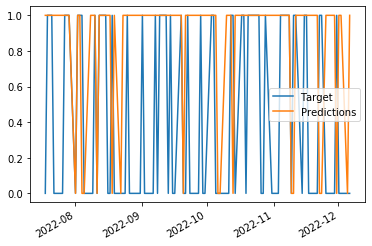

In [13]:
combined = pd.concat({"Target": test["Target"],"Predictions": predictions}, axis=1)
combined.plot()

We can see that the model has significantly low accuracy in predicting correct results. One possible explanation is that since it was trained using all of the stock's history, the price rises were overestimated (as can be seen from the graph of closing price trends through 2021 there was a sharp increase). In the historical test period (July - December 2022), on the other hand, the stock experienced a general depreciation.

## Backtesting

We now want to find a way to make predictions on the entire dataset, not just the last 100 rows. The error estimate will then be more robust. In fact, as discussed above, market conditions over the last 100 days can be atypical.

We will therefore need to backtest. This ensures that we only use data prior to the day we are forecasting and not future days.

The backtesting method will run a loop on the data set and train a model every 750 rows. As usual we will split the data between training and testing, the model will be trained, predictions will be made on the test data.

In [14]:
def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        
        # Fit the random forest model
        model.fit(train[predictors], train["Target"])
        
        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0
        
        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
        
        predictions.append(combined)
    
    return pd.concat(predictions)

In [15]:
RFC = RandomForestClassifier(n_estimators=200,
                             min_samples_split=50,
                             min_samples_leaf=4,
                             max_features='auto',
                             max_depth=30,
                             bootstrap=True)
predictions = backtest(data, RFC, predictors)
predictions["Predictions"].value_counts()

0.0    2656
1.0     951
Name: Predictions, dtype: int64

In [16]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5352260778128286

Using backtesting seems to have improved accuracy. However, the result is still not satisfying.

## Improving accuracy

The simplest idea to try to improve the accuracy of the model is to add additional indicators. One of the most commonly used indicators is the **Moving Average Convergence Divergence** (MACD) Indicator and its signal line.

In [17]:
exp1 = data['Close'].ewm(span=12, adjust=False).mean()
exp2 = data['Close'].ewm(span=26, adjust=False).mean()
macd = exp1 - exp2
exp3 = macd.ewm(span=9, adjust=False).mean()

In [18]:
data['MACD'] = macd
data['Signal Line'] = exp3
full_predictors = predictors + ['MACD', 'Signal Line']

In [19]:
predictions = backtest(data, RFC, full_predictors)
precision_score(predictions["Target"], predictions["Predictions"])

0.5433604336043361

As we can observe, by simply adding these parameters the accuracy of the model is not significantly modified.

We will now try to make use of another indicator, called **Heikin Ashi's indicator**. 

In [20]:
ha_df = price_df[['Open', 'High', 'Low', 'Close']]
ha_df['Date'] = range(ha_df.shape[0])
ha_df = ha_df.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]

for i in range(ha_df.shape[0]):
    if i > 0:
        ha_df.loc[ha_df.index[i],'Open'] = (price_df['Open'][i-1] + price_df['Close'][i-1])/2
    ha_df.loc[ha_df.index[i],'Close'] = (price_df['Open'][i] + price_df['Close'][i] + price_df['Low'][i] +  price_df['High'][i])/4
    
ha_df = ha_df.iloc[1:,:]

In [21]:
from mpl_finance import candlestick_ohlc

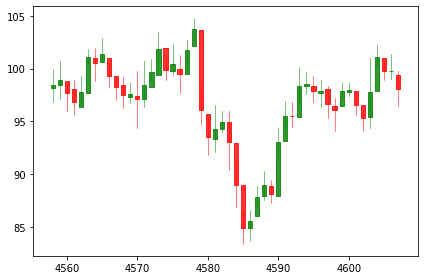

In [22]:
# Plot of the last 50 daiys using HA indicator
fig, ax = plt.subplots()
candlestick_ohlc(ax,ha_df.tail(50).values,width=0.6, colorup='green', colordown='red', alpha=0.8)
fig.tight_layout()
fig.show()

In [23]:
data['HA Open'] = ha_df['Open']
data['HA Close'] = ha_df['Close']

In [24]:
full_predictors = predictors + ['MACD', 'Signal Line', 'HA Open', 'HA Close']
predictions = backtest(data, RFC, full_predictors)
precision_score(predictions["Target"], predictions["Predictions"])

0.5466297322253001

Once again the improvement in accuracy does not seem to be very significant. However, we observe how accuracy has gradually improved by increasing the number of indicators.

## Conclusions

The purpose of this project was to become familiar with Random Forest through the Scikit-learn library and with financial concepts such as MACD and HA indicators. As I expected, market movements are difficult to predict with simple machine learning models. However, considering the right information, we achieved an accuracy better than 50%.

In future developments, it would be interesting to try to predict price movements with different models and considering indicators other than those closely related to prices and volumes. For example, we could consider other economic indicators (interest rates, economic news) or political indicators, prices of stocks in the same industry or of partner companies. 

In [25]:
sys.stderr = sys.__stderr__  # unsilence stderr